# День 03 – Предиктивный анализ II

Продолжаем бороться с оттоком клиентов. Сегодня попробуем еще несколько алгоритмов машинного обучения. Посмотрим на другие метрики качества. И попробуем воспользоваться кросс-валидацией.

## 0. Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_style("darkgrid") #у графиков будет красивая серая подложка

## 1. Загрузка данных

Продолжим работать с датасетом, который вы получили вчера – со стандартизированными признаками и one-hot-encoding.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/School21/day03/bank_data_train_d02.csv', index_col='ID')

In [ ]:
df.head(2)

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,PACK_104,PACK_105,PACK_107,PACK_108,PACK_109,PACK_301,PACK_k01,PACK_m01,PACK_o01,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
146841,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,2.356500,-0.169589,0.477531,-0.248485,-1.004598,...,0,0,0,0,0,0,1,0,0,0
146842,-0.243932,0.016835,-0.044824,1.221828,-0.05133,-0.312371,-0.169589,-0.330458,-0.248485,1.446347,...,0,0,0,0,0,0,0,0,0,0


## 2. Демонстрация дерева

Но снова прежде чем мы перейдем к работе над этим датасетом, хочется продемонстрировать работу другого алгоритма машинного обучения – дерево классификаций. Продолжим для этих целей использовать датасет по виноградникам.

In [ ]:
from sklearn.datasets import load_wine
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df.insert(13, 'CLASS', data.target)
df2 = wine_df.loc[(wine_df.CLASS == 0) | (wine_df.CLASS == 1)]
wine = df2[['alcohol', 'proline', 'CLASS']]

In [ ]:
wine.head(2)

,alcohol,proline,CLASS
0,14.23,1065.0,0
1,13.20,1050.0,0


Напомним, как выглядит график распределения двух признаков

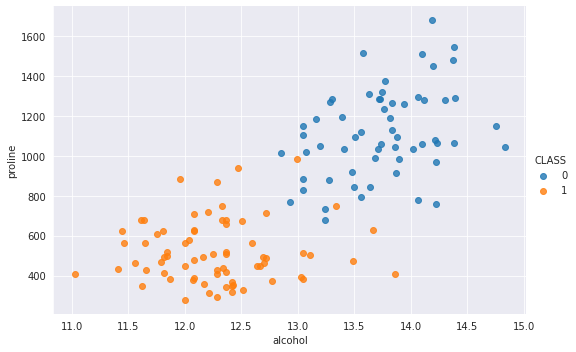

In [ ]:
sns.lmplot(x="alcohol", y="proline", data=wine, fit_reg=False, hue='CLASS', legend=True,
          height=5, aspect=1.5)

In [ ]:
X = wine[['alcohol', 'proline']]
y = wine['CLASS']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=21) #построим дерево, в котором глубина равна двум

In [ ]:
tree_clf.fit(X, y) #обучим модель на данных

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

Проверим, как она справилась с предсказаниями (*да, мы тут не делаем разбиение на train и test, поэтому это немного нечестно :)*)

In [ ]:
predict_tree = tree_clf.predict(X)
accuracy_score(y, predict_tree) * 100

97.6923076923077

Как же дерево в геометрическом смысле работает с пространством признаков? Логрегрессия нам в прошлый раз провела просто прямую линию.

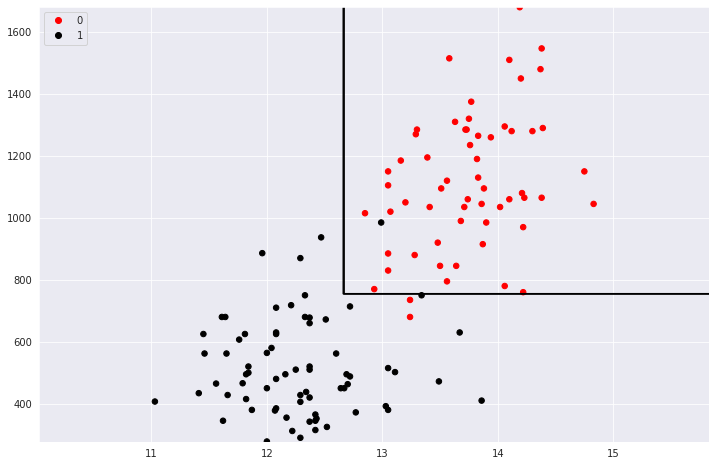

In [ ]:
plt.figure(figsize=(12,8))
a = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=30, cmap='flag')
plot_step = 0.01
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', alpha=0.5)
plt.legend(handles=a.legend_elements()[0], labels=['0', '1'], loc='upper left')
plt.show()

Хм, кажется дерево действует более сложно. Оно способно строить не одну линию, которая отделяет классы, а несколько – создавая линиями сектора. В данном случае, дерево двумя линиями отсекло вина первого виноградника: если у вина уровень алкоголя больше ~12.75 и уровень пролина больше ~750, то это первый виноградник; в противном случае – это второй виноградник.

Можно построить и другую визуализацию, которая демонстрирует, как раз правила, которые мы сформулировали выше. Признаков может быть больше, глубина дерева тоже может быть больше. И эта визуализация подойдет.

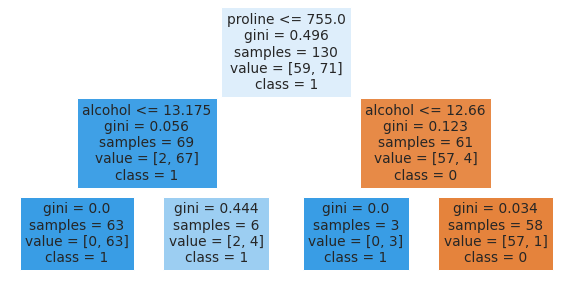

In [ ]:
from sklearn import tree
plt.figure(figsize=(10,5))
tree.plot_tree(tree_clf, feature_names = X.columns, class_names=y.unique().astype('str'), filled = True)
plt.show()

На этой картинке видно, что 0-й класс присваивается тем винам, у кого уровень пролина > 755.0 и уровень алкоголя > 12.66. Примерно то же самое мы поняли и по графику распределения.

## 3. Кросс-валидация

Поговорим теперь про кросс-валидацию.
В прошлый раз для оценки качества модели мы из исходного датасета выделяли тестовую выборку. Если мы будем пробовать другие разные алгоритмы, если мы будем пытаться подобрать наилучшие гиперпараметры этих алгоритмов, то мы неявным образом можем переобучиться на этой тестовой выборке – то есть заточить наши модели под нее слишком хорошо. И когда эта модель встретиться с новыми данными в промышленном использовании, то она может показать качество хуже, чем мы получали на этой тестовой выборке.

Чтобы избежать в том числе этого, была придумана кроссвалидация. Мы по-прежнему отсекаем тестовую выборку, но используем ее только один-два раза уже в конце нашего процесса обучения моделей. Б**о**льшую часть времени работаем с тренировочной выборкой. Кросс-валидация на каждом этапе обучения модели сама берет и еще раз отсекает небольшую часть выборки для валидации модели. Она может это делать, например, 10 раз. И каждый из 10 разов для проверки качества модели будет использоваться новый кусочек тренировочной выборки.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear')
data = cross_val_score(clf, X, y, cv=10, scoring = 'accuracy')

In [ ]:
data

array([0.92307692, 0.92307692, 0.76923077, 0.76923077, 1.        ,
       0.92307692, 0.84615385, 0.92307692, 1.        , 1.        ])

Теперь для понимания, насколько хорошо работает логрегрессия на этом датасете, мы можем взять среднее accuracy.

In [ ]:
data.mean() * 100

90.76923076923077

Посмотрим, как дела у дерева.

In [ ]:
clf2 = DecisionTreeClassifier(max_depth=2, random_state=21)
data2 = cross_val_score(clf2, X, y, cv=10, scoring = 'accuracy')

In [ ]:
data2.mean() * 100

94.61538461538461

Кажется, дерево все-таки показывает лучшее качество, чем логрегрессия.

## 4. Другие метрики качества

И последнее про что мы поговорим – это другие метрики качества. До сих пор мы использовали `accuracy`. Для датасета с винами она хорошо подходит, потому что классы распределены почти поровну. Для датасета по оттоку клиентов – нет. Там доля клиентов, которые ушли, значительно меньше доли текущих клиентов.

### a. Precision и Recall

Представим, что мы можем делать прогноз не по всем винам. Можем выбрать только те вина, в которых мы очень уверены. Например, выбрать 5 штук и в рамках этого прогноза добиться идеальной точности модели. Такова интуиция метрики `precision` (точность) – доля правильно угаданого класса среди тех, по которым мы сделали прогноз. Но, сокращая объем прогноза, мы можем терять в чем-то другом – как много мы выявили сортов вина этого класса. Скорее всего мало, если мы сократили прогноз до 5 штук. Доля правильно угаданного класса среди всех представителей этого класса в выборке – это интуиция метрики `recall` (полнота).

Есть задачи, где может быть важен precision – когда нам важно отвечать за качество нашего решения. Например, если мы считаем кого-то преступником, то мы должны быть в этом очень уверены. Но можно взять другой пример из этой же области – нам важно поймать всех террористов, бегающих по миру, и нам ок с тем, что мы вынуждены будем проверить кучу мирных людей. Нам важен recall и мы готовы смириться с низким precision.

In [ ]:
data = cross_val_score(clf2, X, y, cv=10, scoring = 'precision')
precision = data.mean()
print(precision)

0.9402777777777779


In [ ]:
data = cross_val_score(clf2, X, y, cv=10, scoring = 'recall')
recall = data.mean()
print(recall)

0.9714285714285715


### b. F1 score

Бывают задачи, где нужно и то, и другое примерно поровну. Для этого придумали `F-меру` (`F1 score`). Она является средним гармоническим точности и полноты.

In [ ]:
data = cross_val_score(clf2, X, y, cv=10, scoring = 'f1')
print(data.mean())

0.9521153846153846


In [ ]:
2 * (precision * recall) / (precision + recall)

0.9555993772703686

Поскольку мы считали всё на кросс-валидации и брали усредненные значения precision и recall, то значения посчитанные при помощи библиотеки и вручную не совпали полностью.

### c. ROC AUC

Есть еще одна метрика. Называется, ROC AUC. AUC расшифровывается как area under curve (площадь под кривой ROC). Давайте разберемся как строится эта ROC-кривая. На этой кривой есть два показателя TPR (true positive rate) и FPR (false positive rate). Идея заключается снова в том, чтобы как-то получить сбалансированный показатель: мы хотим одновременно иметь высокую точность и высокую полноту.

Возьмем для примера снова террористов. TPR – это всё тот же recall: доля найденных террористов от их общего числа в выборке. FPR – это доля потревоженных мирных жителей среди всех мирных жителей. Хочется, чтобы TPR был высокий, а FPR низкий.

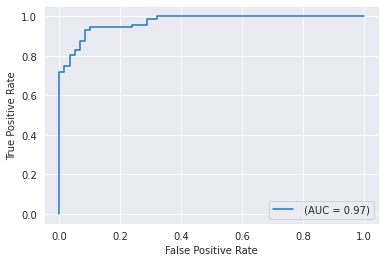

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
clf.fit(X, y)
y_score = clf.decision_function(X)
average_precision = average_precision_score(y, y_score)
fpr, tpr, _ = roc_curve(y, y_score, pos_label=clf.classes_[1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='').plot()

Как же строится этот график? Откуда столько точек? На самом деле алгоритмы машинного обучения могут давать прогноз не только в виде, какой класс они видят для этого объекта, а как вариант могут выдавать вероятность отнесения к этому классу (`.predict_proba(X_test)`). И мы можем сами выбирать пороговое значение, выше которого мы будем считать, что этот объект этого класса. Можем взять 0.5. Все вина, у которых вероятность выше этого значения, будут относиться к первому винограднику. Можем взять 0.9. И тогда все вина, у которых значения выше этого порога, будут относиться к первому винограднику. Так вот, каждая точка на этом графике – это такой вот порог. И для этого порога посчитаны TPR и FPR.

Очевидно, что чем ниже порог мы выберем, тем выше будет полнота (recall), но тем больше будет и FPR. То есть больше мирных жителей нам придется потревожить.

Таким образом, AUC – это площадь под такой вот кривой. Чем лучше работает классификатор, тем выше эта линия на графике будет проходить. В пределе это будет просто прямой угол и площадь под такой кривой будет равна 1.

In [ ]:
data = cross_val_score(clf2, X, y, cv=10, scoring = 'roc_auc')
print(data.mean())

0.9595238095238094


## 5. Самостоятельная часть

Ниже вам нужно самим по инструкции задания построить несколько алгоритмов машинного обучения и в конечном итоге добиться высокого уровня качества модели.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
sns.set_style("darkgrid") #серая подложка

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/School21/day03/bank_data_train_d02.csv', index_col='ID')

In [ ]:
df.head(2)

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,PACK_104,PACK_105,PACK_107,PACK_108,PACK_109,PACK_301,PACK_k01,PACK_m01,PACK_o01,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
146841,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,2.356500,-0.169589,0.477531,-0.248485,-1.004598,...,0,0,0,0,0,0,1,0,0,0
146842,-0.243932,0.016835,-0.044824,1.221828,-0.05133,-0.312371,-0.169589,-0.330458,-0.248485,1.446347,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET', axis=1),
                                                    df['TARGET'],
                                                    test_size=0.2, random_state=21)

In [ ]:
X_train

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,PACK_103,PACK_104,PACK_105,PACK_107,PACK_108,PACK_109,PACK_301,PACK_k01,PACK_m01,PACK_o01
ID,,,,,,,,,,,,,,,,,,,,,
160587,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,0.125831,-0.248485,-1.004598,...,0,0,0,0,0,0,0,0,0,0
328947,-0.243932,-0.380232,-0.044824,-0.515896,-0.05133,-0.312371,-0.169589,-0.299435,-0.232094,-0.605184,...,0,0,0,0,0,0,0,0,0,1
583619,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.231624,0.721664,-1.004598,...,0,0,0,0,0,0,0,0,0,0
155922,-0.243932,-0.050653,-0.044824,0.007438,-0.05133,-0.312371,-0.169589,-0.353235,-0.204466,0.894885,...,0,0,1,0,0,0,0,0,0,0
468688,-0.243932,-0.380232,-0.044824,-0.382398,-0.05133,-0.312371,-0.169589,1.097222,-0.248485,-0.211645,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249311,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.348316,-0.248485,-1.004598,...,0,0,0,1,0,0,0,0,0,0
321783,-0.243932,-0.363446,-0.044824,3.403086,-0.05133,-0.312371,-0.169589,-0.327134,-0.169615,-0.053054,...,0,0,0,0,0,0,0,1,0,0
399839,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.351344,0.990450,-1.004598,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,TURNOVER_DYNAMIC_IL_1M,AMOUNT_RUB_SUP_PRC,REST_DYNAMIC_FDEP_1M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,...,PACK_103,PACK_104,PACK_105,PACK_107,PACK_108,PACK_109,PACK_301,PACK_k01,PACK_m01,PACK_o01
ID,,,,,,,,,,,,,,,,,,,,,
213012,-0.243932,-0.380232,-0.044824,0.302946,-0.05133,-0.312371,-0.169589,-0.353235,0.019832,1.282951,...,0,0,1,0,0,0,0,0,0,0
425165,-0.243932,-0.231620,-0.044824,3.277466,-0.05133,-0.312371,-0.169589,-0.325711,-0.248485,3.488802,...,0,0,0,0,0,0,0,0,0,0
418831,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.027859,-0.248485,-1.004598,...,0,0,0,0,0,0,0,0,0,1
309967,-0.243932,0.158985,-0.044824,-0.343662,-0.05133,-0.312371,-0.169589,-0.353235,-0.238125,-0.066845,...,0,0,1,0,0,0,0,0,0,0
541027,-0.243932,-0.380232,-0.044824,-0.488284,-0.05133,-0.312371,-0.169589,-0.331052,-0.206498,0.212969,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582743,-0.243932,-0.380232,-0.044824,-0.582347,-0.05133,-0.312371,-0.169589,-0.318002,-0.248485,-1.004598,...,0,0,0,0,0,0,0,1,0,0
261292,-0.243932,-0.380232,-0.044824,3.220062,-0.05133,-0.312371,-0.169589,-0.336969,-0.248485,1.691442,...,1,0,0,0,0,0,0,0,0,0
180844,-0.243932,0.699516,-0.044824,2.003320,-0.05133,-0.312371,-0.169589,3.184797,-0.248485,1.771522,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
y_train

ID
160587    0
328947    0
583619    0
155922    0
468688    0
         ..
249311    0
321783    1
399839    0
563123    0
247886    0
Name: TARGET, Length: 284152, dtype: int64

In [ ]:
y_test

ID
213012    0
425165    0
418831    1
309967    0
541027    0
         ..
582743    1
261292    0
180844    0
283693    0
238505    0
Name: TARGET, Length: 71038, dtype: int64

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBClassifier


ДЕРЕВО КЛАССИФИКАЦИИ

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=21) #построим дерево, в котором глубина равна двум

In [ ]:
parametrs={'max_depth':range(2,5, 1)}

In [ ]:
grid=GridSearchCV(tree_clf, parametrs, cv=5, scoring = 'roc_auc') #поиск лучших параметров

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=21),
             param_grid={'max_depth': range(2, 5)}, scoring='roc_auc')

In [ ]:
grid.best_params_ #лучшие параметры

{'max_depth': 4}

In [ ]:
grid.best_score_

0.7750844329800122

СЛУЧАЙНЫЙ ЛЕС

In [ ]:
rf_clf = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=21) #случайный лес

In [ ]:
parametrs2={'max_depth':range(2,5, 1)}

In [ ]:
rf_grid=GridSearchCV(rf_clf, parametrs2, cv=5, scoring = 'roc_auc') #поиск лучших параметров

In [ ]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=2, n_estimators=10,
                                             random_state=21),
             param_grid={'max_depth': range(2, 5)}, scoring='roc_auc')

In [ ]:
rf_grid.best_params_

{'max_depth': 4}

In [ ]:
rf_grid.best_score_

0.7851099858200786

ГРАДИЕНТНЫЙ БУСТИНГ

In [ ]:
xgb_clf = XGBClassifier(n_estimators=10, objective ='reg:squarederror', max_depth=2, random_state=21) #градиентный бустинг

In [ ]:
parametrs3={'max_depth':range(2,5, 1)}

In [ ]:
xgb_grid=GridSearchCV(xgb_clf, parametrs3, cv=5, scoring = 'roc_auc') #поиск лучших параметров

In [ ]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(max_depth=2, n_estimators=10,
                                     objective='reg:squarederror',
                                     random_state=21),
             param_grid={'max_depth': range(2, 5)}, scoring='roc_auc')

In [ ]:
xgb_grid.best_params_

{'max_depth': 4}

In [ ]:
xgb_grid.best_score_

0.8044145040764867

ЛОГРЕГРЕССИЯ

In [1]:
lr_clf = LogisticRegression(random_state=21, fit_intercept=False, solver='liblinear') #логрегрессия

NameError: ignored

In [ ]:
params = {'C':[1.0,10,100]}

In [ ]:
lr_grid=GridSearchCV(lr_clf, params, cv=5, scoring = 'roc_auc') #поиск лучших параметров

In [ ]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(fit_intercept=False, random_state=21,
                                          solver='liblinear'),
             param_grid={'C': [1.0, 10, 100]}, scoring='roc_auc')

In [ ]:
lr_grid.best_params_

{'C': 1.0}

In [ ]:
lr_grid.best_score_

0.745585542008787

ДВЕ ЛУЧШИЕ МОДЕЛИ НА ТРЕНИРОВОЧНОЫ ВЫБОРКЕ

In [ ]:
xgb_clf = XGBClassifier(n_estimators=10, objective ='reg:squarederror', max_depth=4, random_state=21)

In [ ]:
xgb_best = xgb_clf.fit(X_train, y_train)

In [ ]:
rf_clf = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=21)

In [ ]:
rf_best = rf_clf.fit(X_train, y_train)

 ROC-AUC на тестовой выборке

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

In [ ]:
data = cross_val_score(xgb_clf, X_test, y_test, cv=10, scoring = 'roc_auc')
print(data.mean())

0.8082215306815188


In [ ]:
data = cross_val_score(rf_clf, X_test, y_test, cv=10, scoring = 'roc_auc')
print(data.mean())

0.7941631581194524


ТОП 10 ПРИЗНАКИ

In [ ]:
xgb_clf.predict_proba(X_test)

array([[0.6374768 , 0.36252323],
       [0.76376396, 0.23623604],
       [0.6813028 , 0.31869718],
       ...,
       [0.8182585 , 0.18174148],
       [0.7980577 , 0.2019423 ],
       [0.8124019 , 0.18759808]], dtype=float32)

In [ ]:
y_pred = xgb_clf.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
sum(y_test == y_pred)/len(y_test)

0.9196064078380585

In [ ]:
sum(y_test == 0) / y_test.size * 100 #не сбалансирован

91.96064078380584

In [ ]:
sns.set_style("darkgrid")

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(12,5))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

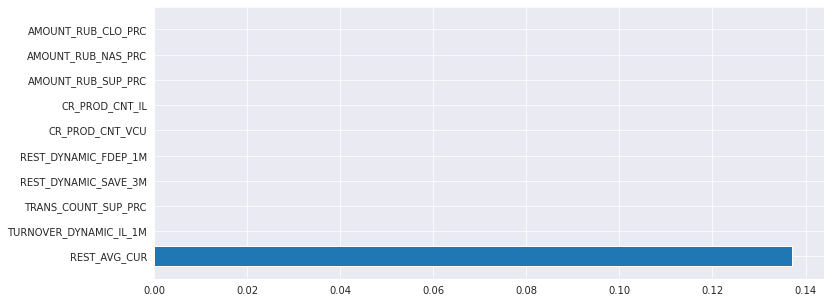

In [ ]:
f_importances(abs(xgb_clf.feature_importances_[0:10]), X_train.columns, top=10)

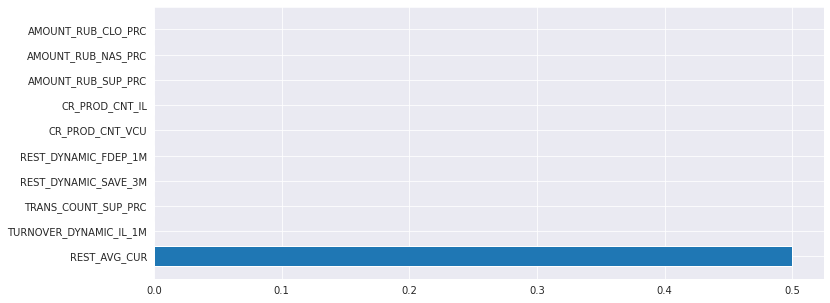

In [ ]:
f_importances(abs(rf_clf.feature_importances_[0:10]), X_train.columns, top=10)

In [ ]:
import pickle
file_name='best_model.sav'
pickle.dump(xgb_clf,  open(file_name, 'wb')) #сохраняем бустинг

In [ ]:
file_name='good_model.sav'
pickle.dump(rf_clf,  open(file_name, 'wb')) #сохраняем случайный лес

In [ ]:
xgb_clf2 = pickle.load(open('/content/drive/MyDrive/School21/day03/best_model.sav', 'rb'))
result1 = cross_val_score(xgb_clf2, X_test, y_test, cv=5, scoring = 'roc_auc')
print(result1.mean())

0.8080008924654647


In [ ]:
rf_clf2 = pickle.load(open('/content/drive/MyDrive/School21/day03/good_model.sav', 'rb'))
result2 = cross_val_score(rf_clf2, X_test, y_test, cv=5, scoring = 'roc_auc')
print(result2.mean())

0.7936287742239274
